# Importing Libraries

In [273]:
import warnings
warnings.filterwarnings("ignore")

In [191]:
!pip install datasets

In [192]:
!pip install rouge

In [274]:
! pip install torch==1.8.2+cu111 torchvision==0.9.2+cu111 torchaudio===0.8.2 -f https://download.pytorch.org/whl/lts/1.8/torch_lts.html
! pip install datasets
! pip install rouge

Looking in links: https://download.pytorch.org/whl/lts/1.8/torch_lts.html
ERROR: Could not find a version that satisfies the requirement torch==1.8.2+cu111 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2, 2.2.0, 2.2.1, 2.2.2)
ERROR: No matching distribution found for torch==1.8.2+cu111


In [275]:
! pip install transformers

In [276]:
!pip install transformers[torch]

In [277]:
!pip install accelerate

In [252]:
from google.colab import drive
from datasets import load_dataset

import nltk
import string
from collections import Counter
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, \
    Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot
from rouge import Rouge
from bs4 import BeautifulSoup

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Loading Data

In [194]:
# Connecting to drive to store the models
drive.mount('/content/drive')

In [195]:
# Loading the data set
dataset = load_dataset("multi_news")
df = dataset['train'].to_pandas()

In [196]:
df.rename(columns={'document': 'text'}, inplace=True)

In [197]:
df.head(2)

,text,summary
0,"National Archives \n \n Yes, it’s that time ag...",– The unemployment rate dropped to 8.2% last m...
1,LOS ANGELES (AP) — In her first interview sinc...,"– Shelly Sterling plans ""eventually"" to divorc..."


# Data Pre-Processing

In [198]:
df.info() #Getting the info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44972 entries, 0 to 44971
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     44972 non-null  object
 1   summary  44972 non-null  object
dtypes: object(2)
memory usage: 702.8+ KB


In [199]:
df.isnull().sum() #Checking the null records

text       0
summary    0
dtype: int64

In [200]:
df.duplicated().sum() #Checking the duplicate records

0

In [201]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [202]:
def text_strip(s):
    '''
    This function is used to remove the punctuations, special characters, and stopwords from the text.
    '''
    # Convert the text to lowercase
    s = s.lower()

    # Removing punctuations using the translate method
    s = s.translate(str.maketrans('', '', string.punctuation))

    # Replacing special characters with spaces using regular expressions
    s = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(s))

    # Replacing multiple spaces with a single space
    s = re.sub("(\.\s+)", ' ', str(s))
    s = re.sub("(\-\s+)", ' ', str(s))
    s = re.sub("(\:\s+)", ' ', str(s))

    # Expand contractions using a predefined mapping
    s = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in s.split(" ")])

    # Removing punctuations again after expanding contractions
    s = s.translate(str.maketrans('', '', string.punctuation))

    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    return ' '.join(word for word in s.split() if word not in stop_words)

In [203]:
text = []
for t in df['text']:
    text.append(text_strip(t))

summary = []
for t in df['summary']:
    summary.append(text_strip(t))

In [204]:
# Adding the START and END to the summaries
summary = ['_START_ '+ str(t) + ' _END_' for t in summary]

In [205]:
df['cleaned_text'] = pd.Series(text)
df['cleaned_summary'] = pd.Series(summary)

In [206]:
df.head(2)

,text,summary,cleaned_text,cleaned_summary
0,"National Archives \n \n Yes, it’s that time ag...",– The unemployment rate dropped to 8.2% last m...,national archives yes it’s time folks it’s fir...,_START_ – unemployment rate dropped 82 last mo...
1,LOS ANGELES (AP) — In her first interview sinc...,"– Shelly Sterling plans ""eventually"" to divorc...",los angeles ap — first interview since nba ban...,_START_ – shelly sterling plans eventually div...


In [207]:
df = df.dropna(axis=0)

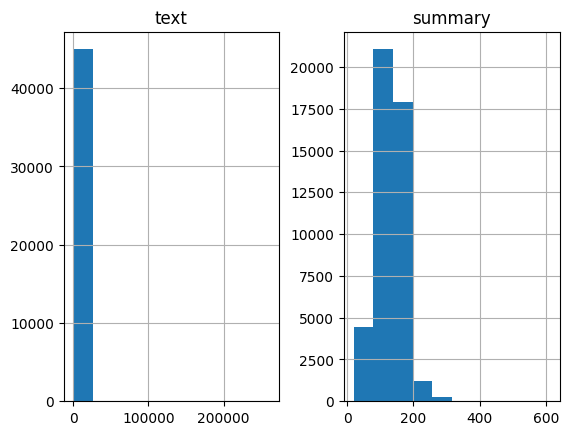

In [208]:
# This code will display the distribution of lengths on text and summaries
text_count = []
summary_count = []

for sent in df['cleaned_text']:
    text_count.append(len(sent.split()))

for sent in df['cleaned_summary']:
    summary_count.append(len(sent.split()))

graph_df = pd.DataFrame()

graph_df['text'] = text_count
graph_df['summary'] = summary_count

graph_df.hist(bins = 10)
plt.show()

As we can see, we have outliers in the text. So, we are setting boundaries on the text and summary lengths to sample the dataset as the data set is huge

In [209]:
#Check how many records of summary have 128 words
count=0
for i in df['cleaned_summary']:
    if(len(i.split())<=128):
        count=count+1
print(count)

21081


In [210]:
# Check how many records 0f text have 1024 words
cnt = 0
for i in df['cleaned_text']:
    if len(i.split()) <= 1024:
        cnt = cnt + 1
print(cnt)

29376


In [211]:
# Model to summarize the text between 0-1024 words for text and 0-128 words for summary
max_text_len = 1024
max_summary_len = 128

In [212]:
# Selecting the text and summaries which fall below max length
cleaned_text = np.array(df['cleaned_text'])
cleaned_summary= np.array(df['cleaned_summary'])

short_text = []
short_summary = []

for i in range(len(cleaned_text)):
    if len(cleaned_summary[i].split()) <= max_summary_len and len(cleaned_text[i].split()) <= max_text_len:
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

filtered_df = pd.DataFrame({'text': short_text,'summary': short_summary})

In [213]:
filtered_df.head()

,text,summary
0,national archives yes it’s time folks it’s fir...,_START_ – unemployment rate dropped 82 last mo...
1,los angeles ap — first interview since nba ban...,_START_ – shelly sterling plans eventually div...
2,gaithersburg md ap — small private jet crashed...,_START_ – twinengine embraer jet faa describes...
3,tucker carlson exposes sexism twitter updated ...,_START_ – tucker carlson deep doodoo conservat...
4,wtf howard stern recently completed als ice bu...,_START_ – howard stern nominated interesting t...


In [214]:
filtered_df.shape

(16604, 2)

We noticed that some summaries are larger compare to texts. This summaries process may include redundant information.

In [215]:
# This will check the count of summaries that are larger compare to text
count = 0
for index, row in filtered_df.iterrows():
    if len(row['text'].split()) < len(row['summary'].split()):
        count += 1

print(count)

238


In [216]:
# Removing the records where summary length is larger than the text
filtered_df = filtered_df[filtered_df.apply(lambda row: len(row['text'].split()) > len(row['summary'].split()), axis=1)]

In [217]:
filtered_df.shape

(16357, 2)

In [218]:
# Adding sostok and eostok

filtered_df['summary'] = filtered_df['summary'].apply(lambda x: 'sostok ' + x + ' eostok')
filtered_df.head(2)

,text,summary
0,national archives yes it’s time folks it’s fir...,sostok _START_ – unemployment rate dropped 82 ...
1,los angeles ap — first interview since nba ban...,sostok _START_ – shelly sterling plans eventua...


In [219]:
# Splitting the data into train and validation
x_train, x_val, y_train, y_val = train_test_split(
    np.array(filtered_df["text"]),
    np.array(filtered_df["summary"]),
    test_size=0.2,
    random_state=0,
    shuffle=True,
)

# Preparing Tokenizers

In [220]:
# Preparing a tokenizer on text data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))

In [221]:
# Getting the counts and percentage of rare words
# Threshold is set to 5, means words that are repeated less than 5 time are considered rare
thresh = 5

cnt = 0
tot_cnt = 0

for key, value in x_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if value < thresh:
        cnt = cnt + 1

print("Size of the vocabulary: ", tot_cnt)
print("Count of rare words: ", cnt)
print("% of rare words in vocabulary: ", (cnt / tot_cnt) * 100)
print("Count of most common words: ", tot_cnt-cnt)

Size of the vocabulary:  218724
Count of rare words:  161506
% of rare words in vocabulary:  73.84009070792415
Count of most common words:  57218


In [222]:
# Preparing a tokenizer
# Not considering the rare words
x_tokenizer = Tokenizer(num_words = tot_cnt - cnt)
x_tokenizer.fit_on_texts(list(x_train))

# Converting text sequences to integer sequences
x_tr_seq = x_tokenizer.texts_to_sequences(x_train)
x_val_seq = x_tokenizer.texts_to_sequences(x_val)

# Pading zero's upto maximum length
x_tr = pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val = pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')


x_voc = x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 57219


In [223]:
# Preparing a tokenizer on summary data
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

thresh = 5
cnt = 0
tot_cnt = 0

for key, value in y_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if value < thresh:
        cnt = cnt + 1

print("Size of the vocabulary: ", tot_cnt)
print("Count of rare words: ", cnt)
print("% of rare words in vocabulary: ", (cnt / tot_cnt) * 100)
print("Count of most common words: ", tot_cnt-cnt)

# Preparing a tokenizer
# not considering the rare words
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
y_tokenizer.fit_on_texts(list(y_train))

# Converting text sequences to integer sequences
y_tr_seq = y_tokenizer.texts_to_sequences(y_train)
y_val_seq = y_tokenizer.texts_to_sequences(y_val)

# Pading zero's upto maximum length
y_tr = pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val = pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

y_voc = y_tokenizer.num_words + 1

print("Size of vocabulary in Y = {}".format(y_voc))

Size of the vocabulary:  77611
Count of rare words:  57592
% of rare words in vocabulary:  74.2059759570164
Count of most common words:  20019
Size of vocabulary in Y = 20020


In [224]:
ind = []

# Iterating over each sample in the dataset
for i in range(len(y_tr)):
    cnt = 0
    # Counting the number of non-zero tokens in the summary
    for j in y_tr[i]:
        if j != 0:
            cnt = cnt + 1
    # If the count is 2 (indicating only 'START' and 'END' tokens are present), adding the index to the list
    if cnt == 2:
        ind.append(i)

# Removing samples with empty summaries from both x_tr and y_tr
y_tr = np.delete(y_tr, ind, axis=0)
x_tr = np.delete(x_tr, ind, axis=0)


In [225]:
ind = []
for i in range(len(y_val)):
    cnt = 0
    for j in y_val[i]:
        if j != 0:
            cnt = cnt + 1
    if cnt == 2:
        ind.append(i)

y_val = np.delete(y_val, ind, axis=0)
x_val = np.delete(x_val, ind, axis=0)

# Seq2Seq Model with LSTM

In [ ]:
latent_dim = 300  # Dimensionality of the latent space
embedding_dim = 200  # Dimensionality of the word embeddings

# Encoder
encoder_inputs = Input(shape=(max_text_len, ))

# Embedding layer for input sequences
enc_emb = Embedding(x_voc, embedding_dim, trainable=True)(encoder_inputs)

# First LSTM layer of the encoder
encoder_lstm1 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output1, state_h1, state_c1) = encoder_lstm1(enc_emb)

# Second LSTM layer of the encoder
encoder_lstm2 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output2, state_h2, state_c2) = encoder_lstm2(encoder_output1)

# Third LSTM layer of the encoder
encoder_lstm3 = LSTM(latent_dim, return_state=True,
                     return_sequences=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_outputs, state_h, state_c) = encoder_lstm3(encoder_output2)

# Setting up the decoder, using encoder_states as the initial state
decoder_inputs = Input(shape=(None, ))

# Embedding layer for decoder input sequences
dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True,
                    return_state=True, dropout=0.4,
                    recurrent_dropout=0.2)
(decoder_outputs, decoder_fwd_state, decoder_back_state) = \
    decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Dense layer to output probabilities over the target vocabulary
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Defining the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

In [227]:
# Compiling the model with RMSprop optimizer and sparse categorical cross-entropy loss function
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

# Early stopping callback to prevent overfitting by monitoring validation loss
# If the validation loss stops decreasing for 'patience' number of epochs, training will stop
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

## Training Model

In [ ]:
history=model.fit([x_tr, y_tr[:,:-1]],
                  y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:,1:],
                  epochs=5,
                  callbacks=[es],
                  batch_size=32,
                  validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:])
                 )

Epoch 1/5
21/21 [==============================] - 301s 14s/step - loss: 4.4956 - val_loss: 2.9031
Epoch 2/5
21/21 [==============================] - 288s 14s/step - loss: 3.0740 - val_loss: 2.8688
Epoch 3/5
21/21 [==============================] - 288s 14s/step - loss: 2.9755 - val_loss: 2.7069
Epoch 4/5
21/21 [==============================] - 288s 14s/step - loss: 2.8941 - val_loss: 2.7049
Epoch 5/5
21/21 [==============================] - 291s 14s/step - loss: 2.8545 - val_loss: 2.6406


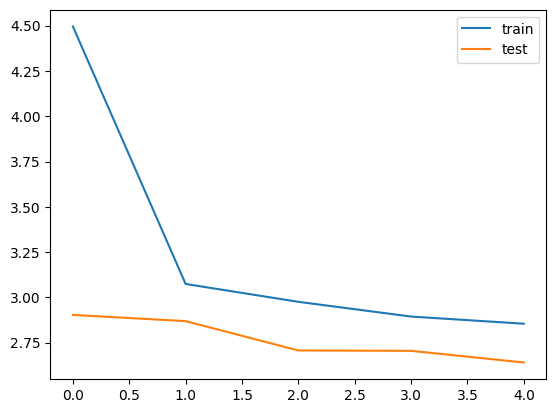

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [181]:
# Saving the model
model.save_weights('/content/drive/MyDrive/Colab Notebooks/NLP/Project/Newss2sModel')

In [182]:
# Loading the model
model = model.load_weights('/content/drive/MyDrive/Colab Notebooks/NLP/Project/Newss2sModel')

## Generating Predictions and Rouge scores

In [183]:
# Creating a reverse mapping from indices to words for the target language
reverse_target_word_index = y_tokenizer.index_word

# Creating a reverse mapping from indices to words for the source language
reverse_source_word_index = x_tokenizer.index_word

# Creating a mapping from words to indices for the target language
target_word_index = y_tokenizer.word_index


In [184]:
# Encoding the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs,
                      state_h, state_c])


# Decoder Setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim, ))
decoder_state_input_c = Input(shape=(latent_dim, ))
decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))

# Geting the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, setting the initial states to the states from the previous time step
(decoder_outputs2, state_h2, state_c2) = decoder_lstm(dec_emb2,
        initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,
                      decoder_state_input_h, decoder_state_input_c],
                      [decoder_outputs2] + [state_h2, state_c2])

In [185]:
def decode_sequence(input_seq):
    # Encoding the input sequence to obtain the encoder output, hidden state, and cell state.
    (e_out, e_h, e_c) = encoder_model.predict(input_seq)

    # Initializing the target sequence with a single 'start' token.
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = target_word_index['sostok']  # Start token index

    stop_condition = False  # Flag to control the decoding process
    decoded_sentence = ''   # Initialize the decoded sentence

    # Decoding the sequence until the stop condition is met
    while not stop_condition:
        # Predicting the next token based on the current target sequence and encoder states
        (output_tokens, h, c) = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Geting the index of the token with the highest probability
        sampled_token_index = np.argmax(output_tokens[0, -1, :])

        # Converting the token index to its corresponding word
        sampled_token = reverse_target_word_index[sampled_token_index]

        # Appending the word to the decoded sentence if it's not the end token
        if sampled_token != 'eostok':
            decoded_sentence += ' ' + sampled_token

        # Checking if the end token is reached or the maximum length is exceeded
        if sampled_token == 'eostok' or len(decoded_sentence.split()) >= max_summary_len - 1:
            stop_condition = True

        # Updating the target sequence with the predicted token index
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Updating the encoder states for the next iteration
        (e_h, e_c) = (h, c)

    return decoded_sentence

In [186]:
def seq2summary(input_seq):
  '''
  This function converts a sequence of indices to a summary
'''
  newString = ''
  # Iterating over each index in the input sequence
  for i in input_seq:
      # Checking if the index is not equal to 0 (padding), start token, or end token
      if i != 0 and i != target_word_index['sostok'] and i != target_word_index['eostok']:
          # Appending the corresponding word to the newString along with a space
          newString = newString + reverse_target_word_index[i] + ' '
  return newString

def seq2text(input_seq):
  '''
  This function converts a sequence of indices to a text
  '''
  newString = ''
  for i in input_seq:
      # Checking if the index is not equal to 0 (padding)
      if i != 0:
          # Appending the corresponding word to the newString along with a space
          newString = newString + reverse_source_word_index[i] + ' '
  return newString


In [239]:
# Initializing Rouge for calculating ROUGE scores
rouge = Rouge()

# Calculating ROUGE scores for each pair of original and predicted summaries
rouge_scores = []
for i in range(10):
    text = seq2text(x_tr[i])
    original_summary = seq2summary(y_tr[i])
    predicted_summary = decode_sequence(x_tr[i].reshape(1, max_text_len))

    rouge_scores.append(rouge.get_scores(predicted_summary, original_summary)[0])

# Organizing the results into a DataFrame
df_results = pd.DataFrame({
    'text': [seq2text(x_tr[i]) for i in range(10)],
    'original_summary': [seq2summary(y_tr[i]) for i in range(10)],
    'predicted_summary': [decode_sequence(x_tr[i].reshape(1, max_text_len)) for i in range(10)],
    'rouge1': [score['rouge-1']['f'] for score in rouge_scores],  # ROUGE-1 scores
    'rouge2': [score['rouge-2']['f'] for score in rouge_scores]   # ROUGE-2 scores
})


ROUGE (Recall-Oriented Understudy for Gisting Evaluation) is a set of metrics used to evaluate the quality of summaries generated by automatic summarization systems.
It measures the overlap between the generated summary and the reference summary, focusing on recall, precision, and F1-score of n-grams (unigrams, bigrams, etc.)

In [327]:
# ROUGE scores from the DataFrame
rouge1_scores = df_results['rouge1']

# Calculate precision, recall, and F1-score
precision_rouge1 = rouge1_scores.mean()
recall_rouge1 = rouge1_scores.mean()
f1_rouge1 = 2 * (precision_rouge1 * recall_rouge1) / (precision_rouge1 + recall_rouge1)

# Print the results
print("ROUGE-1 Precision:", precision_rouge1)
print("ROUGE-1 Recall:", recall_rouge1)
print("ROUGE-1 F1-score:", f1_rouge1)

ROUGE-1 Precision: 0.029162156663601575
ROUGE-1 Recall: 0.029162156663601575
ROUGE-1 F1-score: 0.029162156663601575


In [231]:
# Seq2seq LSTM - rouge 1
df_results['rouge1'].mean()

0.029162156663601575

# T5 - Tranformer (Text-To-Text Transfer Transformer)

In [248]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 6.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [278]:
from transformers import AutoTokenizer
from transformers import DataCollatorForSeq2Seq, AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
import accelerate
from transformers import Seq2SeqTrainer
from transformers import TFAutoModelForSeq2SeqLM
from rouge import Rouge

In [279]:
# Getting the data
from datasets import load_dataset
multi_news = load_dataset("multi_news", split="test")

In [281]:
# # Splitting the data into train and test for T5
# from sklearn.model_selection import train_test_split

multi_news = multi_news.train_test_split(test_size=0.2)

## Preparing Tokenizing

In [282]:
# Load the tokenizer for the T5-small model from the Hugging Face model hub
tokenizer = AutoTokenizer.from_pretrained("t5-small")

In [286]:
prefix = "summarize: "

def preprocess_function(examples):
    # Adding the prefix to each document for summarization
    inputs = [prefix + doc for doc in examples["document"]]

    # Tokenizing the inputs using the T5 tokenizer
    # Setting max_length and truncation parameters for both inputs and labels
    model_inputs = tokenizer(inputs, max_length=1024, truncation=True)

    # Tokenizing the summaries using the T5 tokenizer and extract the input_ids
    labels = tokenizer(text=examples["summary"], max_length=128, truncation=True)

    # Assigning the tokenized summaries (input_ids) to the "labels" key in the model_inputs dictionary
    model_inputs["labels"] = labels["input_ids"]

    return model_inputs

In [287]:
tokenized_multi_news = multi_news.map(preprocess_function, batched=True)
# tokenized_multi_news = preprocess_function(train_data)

Map:   0%|          | 0/4497 [00:00<?, ? examples/s]

Map:   0%|          | 0/1125 [00:00<?, ? examples/s]

In [288]:
tokenized_multi_news['train'].to_pandas()

,document,summary,input_ids,attention_mask,labels
0,Kris Humphries to File for Separation – Not Di...,– Poor Kim: Not only have her fairy tale dream...,"[21603, 10, 9375, 3455, 7656, 2593, 12, 7344, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3, 104, 21309, 6777, 10, 933, 163, 43, 160, 1..."
1,"A record 400 farmers attacked in 2017, between...",– The South African government has begun the c...,"[21603, 10, 71, 1368, 4837, 7208, 17263, 16, 4...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3, 104, 37, 1013, 3850, 789, 65, 11173, 8, 15..."
2,"BERKLEY (WXYZ) - October 6, 1966. \n \n \n \n ...",– A Detroit man who long pondered the fate of ...,"[21603, 10, 3, 12920, 439, 3765, 476, 41, 518,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3, 104, 71, 11901, 388, 113, 307, 3, 31462, 2..."
3,Scott Weiland Will Filed ... Ex-Wife Wants to ...,– Scott Weiland's death could end up just as f...,"[21603, 10, 4972, 101, 173, 232, 2003, 7344, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3, 104, 4972, 101, 173, 232, 31, 7, 1687, 228..."
4,His grandfather had lovingly given him his nam...,– Saddam Hussain's name is making it difficult...,"[21603, 10, 978, 18573, 141, 6330, 120, 787, 3...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3, 104, 18875, 7812, 13674, 7, 9, 77, 31, 7, ..."
...,...,...,...,...,...
4492,"Hope Hicks, the former White House communicati...",– Hope Hicks has landed her post-White House g...,"[21603, 10, 6000, 454, 3142, 7, 6, 8, 1798, 19...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3, 104, 6000, 454, 3142, 7, 65, 3, 16349, 160..."
4493,"This morning, Twitter’s Jack Dorsey and Facebo...",– The biggest stars of Wednesday's Senate Inte...,"[21603, 10, 100, 1379, 6, 3046, 22, 7, 4496, 6...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3, 104, 37, 2630, 4811, 13, 2875, 31, 7, 7819..."
4494,What is love bombing? \n \n Love bombing is a ...,– Love at first sight may actually be a warnin...,"[21603, 10, 363, 19, 333, 6417, 53, 58, 2129, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3, 104, 2129, 44, 166, 6398, 164, 700, 36, 3,..."
4495,North Carolina State Archives and State Librar...,"– Writer Salman Rushdie was furious at ""moroni...","[21603, 10, 1117, 5089, 1015, 18499, 11, 1015,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3, 104, 8733, 52, 5158, 348, 20710, 2498, 47,..."


In [309]:
import accelerate

In [289]:
# Loading Model
# Data collator for sequence-to-sequence (seq2seq) tasks, specifically designed for T5 model
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model='t5-small')

# Loading the pre-trained T5-small model for sequence-to-sequence language modeling
# from the Hugging Face model hub
model = AutoModelForSeq2SeqLM.from_pretrained("t5-small")

In [311]:
# Hyperparameters for T5
training_args = Seq2SeqTrainingArguments(
output_dir="./results",
evaluation_strategy="epoch",
learning_rate=2e-5,
per_device_train_batch_size=10,
per_device_eval_batch_size=10,
weight_decay=0.01,
save_total_limit=3,
num_train_epochs=10,
fp16=True,
)

Initializing Trainer

In [ ]:
# Initializing the Seq2SeqTrainer for training and evaluation

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_multi_news["train"],
    eval_dataset=tokenized_multi_news["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

In [ ]:
# Training the T5 Model
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,2.846481
2,3.254700,2.786284
3,3.008600,2.756580
4,2.953500,2.738764
5,2.925500,2.729048
6,2.904300,2.722795
7,2.894800,2.717708
8,2.877600,2.714469
9,2.878900,2.713377
10,2.870900,2.711978


TrainOutput(global_step=4500, training_loss=2.952074951171875, metrics={'train_runtime': 975.317, 'train_samples_per_second': 46.108, 'train_steps_per_second': 4.614, 'total_flos': 1.217264162439168e+16, 'train_loss': 2.952074951171875, 'epoch': 10.0})

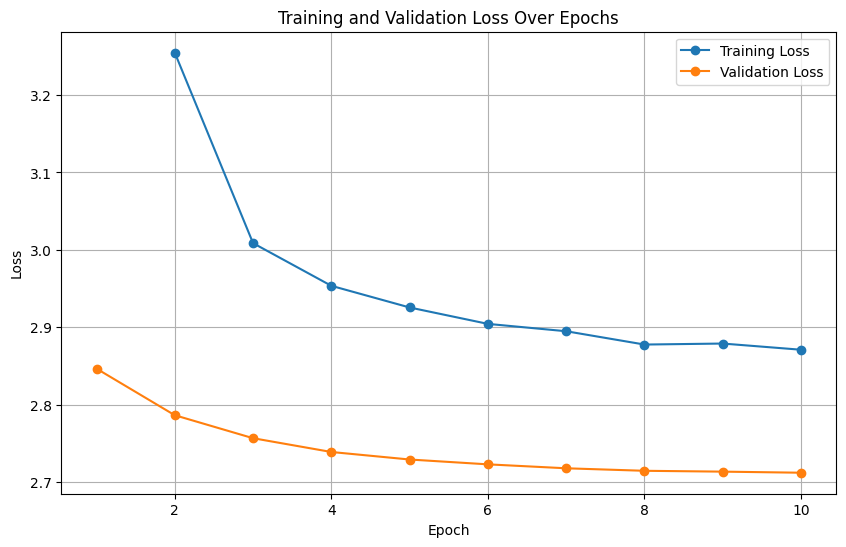

In [237]:
# t5_loss = {
#     'Epoch': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
#     'Training Loss': [np.nan, 3.2547, 3.0086, 2.9535, 2.9255, 2.9043, 2.8948, 2.8776, 2.8789, 2.8709],
#     'Validation Loss': [2.846481, 2.786284, 2.75658, 2.738764, 2.729048, 2.722795, 2.717708, 2.714469, 2.713377, 2.711978]
# }

# t5_loss_df = pd.DataFrame(t5_loss)
plt.figure(figsize=(10, 6))
plt.plot(t5_loss_df['Epoch'], t5_loss_df['Training Loss'], marker='o', label='Training Loss')
plt.plot(t5_loss_df['Epoch'], t5_loss_df['Validation Loss'], marker='o', label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# # Saving the model in drive
# model_dir = "/content/drive/MyDrive/Colab Notebooks/NLP/Project/TModel"
# trainer.save_model(model_dir)

# print("Model saved successfully to Google Drive.")

Model saved successfully to Google Drive.


In [312]:
# Loading the model from the drive
model_dir = "/content/drive/MyDrive/Colab Notebooks/NLP/Project/TModel"
loaded_model = TFAutoModelForSeq2SeqLM.from_pretrained(model_dir)

print("Model loaded successfully from Google Drive.")

All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


Model loaded successfully from Google Drive.


## Generating predictions and rouge scores

In [313]:
def predict_summary(document):
  device = model.device
  # Tokenizing the input document using the tokenizer
  tokenized = tokenizer([document], truncation=True, padding='longest', return_tensors='pt')
  tokenized = {k: v.to(device) for k, v in tokenized.items()}
  tokenized_result = model.generate(**tokenized, max_length=128) # Generating summary
  tokenized_result = tokenized_result.to('cpu')
  predicted_summary = tokenizer.decode(tokenized_result[0]) # convert the generated tokens into Text

  return predicted_summary

In [314]:
def get_rouge_scores(actual_summary, predicted_summary):
  '''This function generates the rouge scores'''
  rouge = Rouge()
  scores = rouge.get_scores(predicted_summary, actual_summary)
  return [scores[0]['rouge-1']['f'], scores[0]['rouge-2']['f'], scores[0]['rouge-l']['f']]

In [315]:
dataset = load_dataset("multi_news")
val_data = dataset['validation'].to_pandas()

In [316]:
val_data.head()

,document,summary
0,Whether a sign of a good read; or a comment on...,– The Da Vinci Code has sold so many copies—th...
1,The deaths of three American soldiers in Afgha...,– A major snafu has hit benefit payments to st...
2,DUBAI Al Qaeda in Yemen has claimed responsibi...,– Yemen-based al-Qaeda in the Arabian Peninsul...
3,"Cambridge Analytica, a data firm that worked f...",– Cambridge Analytica is calling it quits. The...
4,The N.S.A.’s Evolution: The National Security ...,"– A lengthy report in the New York Times, base..."


In [324]:
from rouge import Rouge

# Initialize Rouge
rouge = Rouge()

# Function to calculate ROUGE scores
def get_rouge_scores(human_summary, pred_summary):
    scores = rouge.get_scores(human_summary, pred_summary)
    rouge1_precision = scores[0]["rouge-1"]["p"]
    rouge1_recall = scores[0]["rouge-1"]["r"]
    rouge1_f1score = scores[0]["rouge-1"]["f"]
    return rouge1_precision, rouge1_recall, rouge1_f1score

# Calculate ROUGE scores for each summary in the validation data
precision_list = []
recall_list = []
f1score_list = []

for i in range(len(val_data)):
    human_summary = val_data.loc[i]['summary']
    pred_summary = val_data.loc[i]['pred_summary']
    precision, recall, f1score = get_rouge_scores(human_summary, pred_summary)
    precision_list.append(precision)
    recall_list.append(recall)
    f1score_list.append(f1score)

# Create a DataFrame to store the ROUGE scores
rouge_scores_df = pd.DataFrame({
    'Precision': precision_list,
    'Recall': recall_list,
    'F1-score': f1score_list
})

# Display the DataFrame
print(rouge_scores_df)


    Precision    Recall  F1-score
0    0.133758  0.466667  0.207921
1    0.112994  0.434783  0.179372
2    0.104000  0.361111  0.161491
3    0.106796  0.407407  0.169231
4    0.090909  0.311111  0.140704
5    0.088372  0.441860  0.147287
6    0.131783  0.326923  0.187845
7    0.083871  0.361111  0.136126
8    0.117647  0.545455  0.193548
9    0.156977  0.642857  0.252336
10   0.063584  0.550000  0.113990
11   0.145833  0.466667  0.222222
12   0.088398  0.533333  0.151659
13   0.063380  0.200000  0.096257
14   0.019355  0.093750  0.032086
15   0.074074  0.421053  0.125984
16   0.026201  0.181818  0.045802
17   0.152941  0.433333  0.226087
18   0.150000  0.500000  0.230769
19   0.087838  0.406250  0.144444
20   0.226027  0.673469  0.338462
21   0.141304  0.530612  0.223176
22   0.046053  0.175000  0.072917
23   0.114943  0.465116  0.184332
24   0.040462  0.411765  0.073684
25   0.067633  0.341463  0.112903
26   0.076190  0.228571  0.114286
27   0.092025  0.348837  0.145631
28   0.232558 

In [326]:
rouge_scores_df.mean()

Precision    0.107017
Recall       0.422054
F1-score     0.168713
dtype: float64

In [319]:
# rouge score of validation data
val_data = val_data.iloc[:50,:]
from tqdm import tqdm

rouge1_scores = []
pred_summary_list = []

for i in tqdm(range(50)):

  doc = val_data.loc[i]['document']
  pred_summary = predict_summary(doc)
  human_summary = val_data.loc[i]['summary']

  score = get_rouge_scores(human_summary, pred_summary)

  rouge1_scores.append(score[0])
  pred_summary_list.append(pred_summary)

val_data["pred_summary"] = pred_summary_list

val_data['rouge1'] = rouge1_scores

val_data

100%|██████████| 50/50 [01:04<00:00,  1.28s/it]


,document,summary,pred_summary,rouge1
0,Whether a sign of a good read; or a comment on...,– The Da Vinci Code has sold so many copies—th...,"<pad><extra_id_0>,<extra_id_1>,<extra_id_2>,<e...",0.207921
1,The deaths of three American soldiers in Afgha...,– A major snafu has hit benefit payments to st...,"<pad><extra_id_0> is a national disgrace, one ...",0.179372
2,DUBAI Al Qaeda in Yemen has claimed responsibi...,– Yemen-based al-Qaeda in the Arabian Peninsul...,<pad><extra_id_0> has claimed responsibility f...,0.161491
3,"Cambridge Analytica, a data firm that worked f...",– Cambridge Analytica is calling it quits. The...,"<pad><extra_id_0>,<extra_id_1>,<extra_id_2>, a...",0.169231
4,The N.S.A.’s Evolution: The National Security ...,"– A lengthy report in the New York Times, base...","<pad><extra_id_0>,<extra_id_1>,<extra_id_2>,<e...",0.140704
5,× \n \n remaining of \n \n Thank you for Readi...,– Don Juan de Oñate sought a city of gold when...,"<pad><extra_id_0> the name Etzanoa, a long-los...",0.147287
6,Rep. Anthony Weiner rejected Democratic leader...,– Another bad day for Anthony Weiner: Nancy Pe...,"<pad><extra_id_0>,<extra_id_1>,<extra_id_2>,<e...",0.187845
7,Augmented reality startup Magic Leap is being ...,– An augmented reality startup is being sued f...,"<pad><extra_id_0> the<extra_id_1>,<extra_id_2>...",0.136126
8,Research suggests that the ratio of the length...,– The length of a man's index and ring fingers...,"<pad><extra_id_0>, 100 matched healthy males, ...",0.193548
9,"HOUSTON – Almost two years ago, a pair of Unit...",– A 71-year-old lawyer is suing United Airline...,<pad><extra_id_0> a 71-year-old man is suing U...,0.252336


In [323]:
val_data.head(10)

,document,summary,pred_summary,rouge1
0,Whether a sign of a good read; or a comment on...,– The Da Vinci Code has sold so many copies—th...,"<pad><extra_id_0>,<extra_id_1>,<extra_id_2>,<e...",0.207921
1,The deaths of three American soldiers in Afgha...,– A major snafu has hit benefit payments to st...,"<pad><extra_id_0> is a national disgrace, one ...",0.179372
2,DUBAI Al Qaeda in Yemen has claimed responsibi...,– Yemen-based al-Qaeda in the Arabian Peninsul...,<pad><extra_id_0> has claimed responsibility f...,0.161491
3,"Cambridge Analytica, a data firm that worked f...",– Cambridge Analytica is calling it quits. The...,"<pad><extra_id_0>,<extra_id_1>,<extra_id_2>, a...",0.169231
4,The N.S.A.’s Evolution: The National Security ...,"– A lengthy report in the New York Times, base...","<pad><extra_id_0>,<extra_id_1>,<extra_id_2>,<e...",0.140704
5,× \n \n remaining of \n \n Thank you for Readi...,– Don Juan de Oñate sought a city of gold when...,"<pad><extra_id_0> the name Etzanoa, a long-los...",0.147287
6,Rep. Anthony Weiner rejected Democratic leader...,– Another bad day for Anthony Weiner: Nancy Pe...,"<pad><extra_id_0>,<extra_id_1>,<extra_id_2>,<e...",0.187845
7,Augmented reality startup Magic Leap is being ...,– An augmented reality startup is being sued f...,"<pad><extra_id_0> the<extra_id_1>,<extra_id_2>...",0.136126
8,Research suggests that the ratio of the length...,– The length of a man's index and ring fingers...,"<pad><extra_id_0>, 100 matched healthy males, ...",0.193548
9,"HOUSTON – Almost two years ago, a pair of Unit...",– A 71-year-old lawyer is suing United Airline...,<pad><extra_id_0> a 71-year-old man is suing U...,0.252336


In [321]:
# T5 - Transformer - rouge 1
val_data['rouge1'].mean()

0.16871276145837286